In [1]:
import sys
sys.path.insert(0, "..")

import jax
import jax.numpy as jnp

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import optax
import numpy as np
from matplotlib import pyplot as plt

In [2]:
key = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [35]:
#
# The potential energy function depending on the coordinates
#
def potential(x):
    return -jnp.sqrt(2)/jnp.sqrt(jnp.sum(x**2, axis = -1))


# the hamiltonian
H = module.hamiltonians.Particles(masses = [1], potential = potential, d_space = 3)

In [36]:
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

In [83]:
class Orbital(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__((3,))

        self.h = jax.vmap(self.calc_logpsi_single, in_axes=[None, 0])

    def init_parameters(self, key):
        return {"a": jax.random.normal(key, shape = (25, 3)),
                "b": jax.random.normal(key, shape = (1, 25)),
                "c": jax.random.normal(key, shape = (25,)),
                "d": jax.random.normal(key, shape = (1,))}
    
    def calc_logpsi_single(self, parameters, x):
        r = jnp.sqrt(jnp.sum(x**2))

        x = parameters["a"] @ x
        x = x + parameters["c"]
        x = sigmoid(x)
        x = parameters["b"] @ x
        x = x + parameters["d"]
        x = sigmoid(x)

        return jnp.squeeze(-x*5 - r/5)
    
    def calc_logpsi(self, parameters, x):

        return self.h(parameters, x)

In [105]:
wavefun = Orbital()
parameters = wavefun.init_parameters(key)

In [120]:
parameters

{'a': Array([[-0.86043805,  1.0439065 ,  0.95291257],
        [-0.5805251 , -0.22607778, -0.6282924 ],
        [ 1.1683624 , -1.8606913 ,  0.35048434],
        [-0.03747473, -0.32228175, -0.86621815],
        [-0.7241887 , -0.5999405 , -0.37375018],
        [ 1.3486991 ,  0.11303287,  2.094907  ],
        [-0.05764626, -0.317661  , -0.37323055],
        [ 2.3414443 , -1.6495192 ,  1.8943307 ],
        [ 0.00860409, -0.26936603, -0.23411864],
        [-1.7513473 ,  0.7573321 ,  0.1978057 ],
        [ 1.0332932 ,  1.3758295 ,  0.9018939 ],
        [ 2.6523135 ,  0.44584247, -1.7364532 ],
        [-2.566505  , -1.0746665 , -0.23575802],
        [ 0.3204449 ,  0.07969053, -2.5665045 ],
        [-0.25423414, -1.6685776 , -0.5022264 ],
        [ 0.2976855 ,  0.68277556, -0.7098403 ],
        [ 0.8222631 , -1.4183874 , -1.5653262 ],
        [ 0.4651611 , -0.5925118 ,  0.5522761 ],
        [-0.6850592 ,  0.11935669,  0.5011695 ],
        [ 0.01109232, -0.04616776,  0.01165993],
        [ 0.121

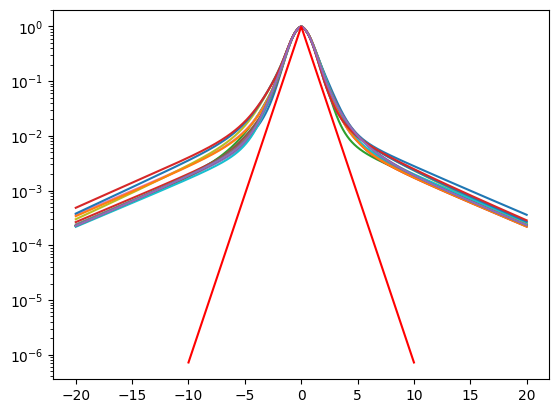

In [119]:
def getLine(phi, theta, r_max = 20):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

getLine = jax.vmap(getLine, in_axes=[0,0])

phi = jax.random.uniform(key, shape = (15,)) * 2 * jnp.pi
theta = jax.random.uniform(key, shape = (15,)) * jnp.pi

r, line = getLine(phi,theta)

for i in range(15):
    prob = wavefun.calc_logpsi(parameters, line[i])
    plt.plot(r[i], jnp.exp(prob)/jnp.max(jnp.exp(prob)))


s = np.linspace(-10, 10, num = 500)
plt.plot(s, jnp.exp(-jnp.abs(s)*jnp.sqrt(2)), color = "red")
plt.yscale("log")

# plt.axvline(jnp.sqrt(2))
# plt.xlim(-5, 5)
# plt.xlim(jnp.sqrt(2)-1, jnp.sqrt(2)+1)


In [125]:
sampler = module.samplers.MCMC(wavefun, variance = 0.1)

In [139]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.691
Expected Energy: -0.94472134
Std of Expected Energy: 0.8096268


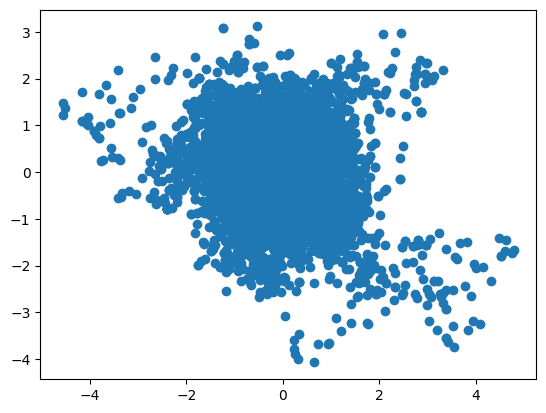

In [140]:
plt.scatter(samples[:, 0], samples[:, 1])

To estimate the gradient of the expected energy via the formula:

$$
\nabla \left< E \right>  = 2\,\Re\, \mathbb{E}\{\nabla \log \Psi [H_{\mathrm{loc}}(r) - \mathbb{E}(E)]\}
$$

we implement a help function:

In [128]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    return jax.tree_util.tree_map(lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0)), grad_log), E, dE

The energy can now be optimised:

In [132]:
Es_ = []
dEs_ = []
ratios_ = []

In [133]:
# define
optimizer = optax.adam(learning_rate=0.005)

# initialise
optimizer_state = optimizer.init(parameters)

for i in tqdm(range(1000)):
    key, _ = jax.random.split(key)
    samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
    grad, E, dE = calc_grad_E(H, wavefun, parameters, samples)

    Es_.append(E)
    dEs_.append(dE)
    ratios_.append(ratio)
    
    updates, optimizer_state = optimizer.update(grad, optimizer_state, parameters)
    parameters = optax.apply_updates(parameters, updates)

Es = np.array(Es_)
dEs = np.array(dEs_) / np.sqrt(10000)
ratios = np.array(ratios_)

100%|██████████| 1000/1000 [00:19<00:00, 52.37it/s]


Text(0.5, 1.0, 'Energy Optimisation')

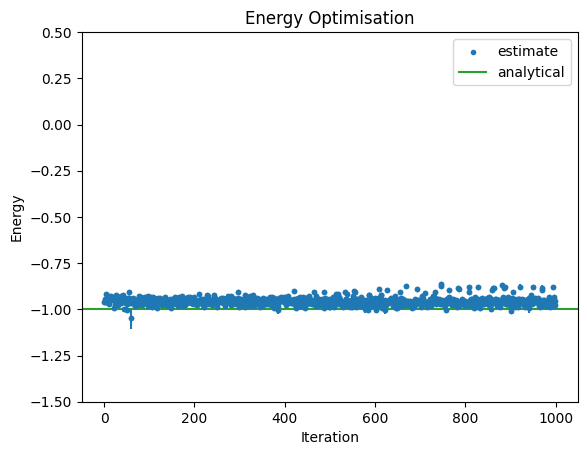

In [138]:
index = np.arange(Es.shape[0])

plt.scatter(index, Es, label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.7, label = "$\\pm \\sigma$", color = "C3")
plt.errorbar(index, Es, yerr = dEs, fmt = ".")
plt.ylim(-1.5,0.5)
# plt.xlim(200,300)
plt.axhline(-1, color = "C2", label = "analytical")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Energy Optimisation")

Text(0.5, 1.0, 'Energy Optimisation')

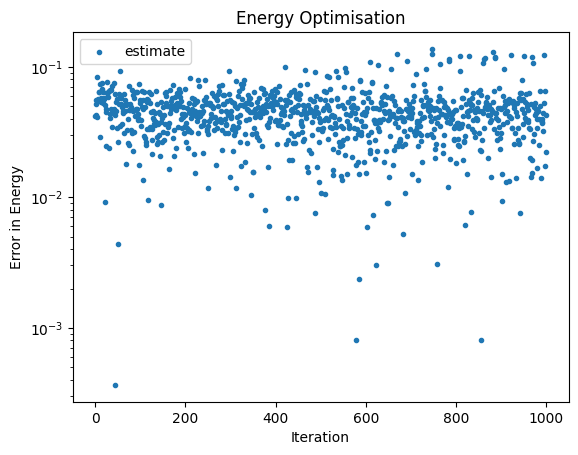

In [136]:
index = np.arange(Es.shape[0])

# plt.errorbar(index, np.abs(Es + 1), yerr = dEs, label = "estimate", fmt = ".")
plt.scatter(index, np.abs(Es + 1), label = "estimate", marker = ".")
# plt.fill_between(index, Es - dEs, Es + dEs, alpha = 0.4, label = "$\\pm \\sigma$")
# plt.ylim(-2,2)
# plt.axhline(-1, color = "C2", label = "analytical")
plt.yscale("log")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Error in Energy")
plt.title("Energy Optimisation")

Now, the variance of the expected energy has decreased, as expected for correct eigenstate:

In [137]:
samples, ratio = sampler.sample(key, parameters, jax.random.normal(key, (3,)), 10000)
H_loc = H.calc_H_loc(wavefun, parameters, samples)

print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))
print("Std of Expected Energy:", jnp.std(H_loc))

Acceptance Ratio: 0.691
Expected Energy: -0.94472134
Std of Expected Energy: 0.8096268


---